# DREaMing of a corpus, round 1: experiments in document similarity

This notebook is going to be a training ground for my machine learning skills (skillz?) and a testing ground for how to best handle travel writing. The first thing I have to do is build a corpus of travel writing published from 1600-1700, which I'll do with a combination of searching and collecting using the [DREaM](http://dream.voyant-tools.org/dream/?corpus=dream) interface, personal critical judgment, and supervised maching learning.

## 1. How do I build a corpus travel literature?

Through the [DREaM](http://dream.voyant-tools.org/dream/?corpus=dream) interface, which provides XML or plain text sets of texts based on search terms. These texts are drawn from a corpus that comprises approximately one-third of all the titles in the Stationer's Register and all of the texts transcribed thus far by the Text Creation Partnership. For more information about the project, see the interface (linked above) and ["Introducing DREaM"](http://earlymodernconversions.com/introducing-dream/).  

My time limits are 1600-1700, which is simple enough. Then, however, the problem begins how to find texts that I would consider "travel writing". Although the definition of travel writing is a contentious one and changes depending on the time period and the scholar (for example, are texts about fake travel considered travel writing? What about itineraries or vade mecums and guides for travellers?), for this project, I chose travel writing to mean a text where travel is described or is a main focus (whether really undertaken by the author or not), and is physical in nature. I will discuss this further below when I talk about refining my corpus, but that was my working definition at that stage in the project.

To find my initial texts, then, I used the "title" search function to look for the most obvious travel-related terms I could think of: "journ&#42;", "voy&#42;", "trav&#42;", and "trip&#42;". This search resulted in 283 texts.

Even this result may inspire questions: 
- Of the 17,201 texts published in the main corpus between 1600-1700, does 1.6% of them being travel match with our expectations?
- How do I find the texts that are about travel but don't have any of those keywords in the titles?

For now, however, let's move on to discussion of the corpora.

The first corpus, which we'll call "travel", consists of 166 texts that are focused on physical travel, primarily outside Britain but some within. I excluded any texts regarding metaphysical travel ( for example, using travel as a metaphor to discuss a relationship with God) and where travel was a subset of a larger text (for example, a large compendium focusing on the proper care of horses that has a small sub-section on travel).

The second corpus, which we'll call "nontravel" (but with "other-" in the file name and as indicated below), consists of 100 texts that are distinctly not travel. These consist of texts from disciplines like law, philosophy, natural science, scandalous tales, parliament decrees, and sermons.

In both of these corpora, I tried to not include any texts that seemed to fall into a "grey zone," so to speak. Therefore, I didn't include geographical texts in nontravel because geographical and travel texts are considered closely related. Similarly, I was unsure of where to put *Pilgrim's Progress*. In these situations, I removed the texts from either corpus and prepared to see whether they would be pulled back in when I ran the machine learning on the corpus.

I am wary of making my corpus too homogenous, but since I am trying to see what texts are similar to this core group, I wanted to have at least a firm starting point.

## But what is actually in this corpus?

Of course, I haven't actually read all the texts in this corpus, and although I skimmed the titles to judge whether it was a travel text, what appears to be a travel text may, in fact, be quite anomalous compared to the rest of the corpus! 

So, then, let's take a look at what our corpus actually looks like. For this example, we'll look at document similarly using relative frequencies. The code below produces two visualizations for document similarity: 
- a dendrogram that shows a cluster hierarchy of documents
- a colour-coded scatterplot that shows the multidimensional term frequencies matrix in a 2D space (suggesting clusters)

Note that we're using relative frequencies rather than TF-IDF. TF-IDF is better at indicating the significance of the term frequency withint eh corpus, but it scales less well for dynamic and large corpora since we need to know in advance how many documents contain a given term.

As a basis, I am drawing largely from the [Classifying Philosophical Texts](https://github.com/htrc/ACS-TT/blob/master/tools/notebooks/ClassifyingPhilosophicalText.ipynb) notebook. 

So, let's experiment, shall we?

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# plot the documents from the corpus
def plot_corpus_similarity(corpus, vectorizer):
    
    # generate the vector, distances and positions
    texts = [corpus.raw(fileid) for fileid in corpus.fileids()]
    documentTermMatrix = vectorizer.fit_transform(texts)
    distances = 1 - cosine_similarity(documentTermMatrix)
    mds = MDS(dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distances)
    
    # plot dendrogram
    linkage_matrix = ward(distances)
    plt.figure(figsize=(8,10))
    dendrogram(linkage_matrix, labels=corpus.fileids(), orientation="right");
    plt.show()  # fixes margins
    
    # plot scatter
    xvalues = positions[:, 0] 
    yvalues = positions[: ,1] 
    plt.figure(figsize=(20,10))
    for x, y, name in zip(xvalues, yvalues, corpus.fileids()):
        plt.scatter(x, y)
        # the colour-coding here is a bit of a hard-coded hack for what is otherwise mostly reusable code
        plt.text(x, y, name.replace(".txt", "")[:25], color='red' if 'other-' in name else 'green')
    plt.show()

### Simple Document Similarities
We'll being by loading our corpus into an NLTK corpus for convenience.
I have a single folder with travel and nontravel texts together, with "other-" in the filename designating non-travel texts. As mentioned above, there are 166 travel texts and 100 nontravel texts.

In [2]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

data_dir = "C:/Users/ASUS/Documents/iPython/data/DREaM"
corpus = PlaintextCorpusReader(data_dir+"/1600-1700corpus", ".*\.txt") 
# the  folder has the travel and nontravel texts together, with  in the filename designating nontravel
# folder consists of 166 travel texts and 100 non-travel texts (as designated with other- in the filename)

Now that we have a corpus, we can try out the functions above by sending our entire corpus with a simple tokenizer that doesn't include stopwords or keywords to keep. Notice that we use a [TF-IDF vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) but we tell the vectorizer to not compute the document frequencies (use_idf=False) which simply normalizes (relativizes) the term frequencies by document.

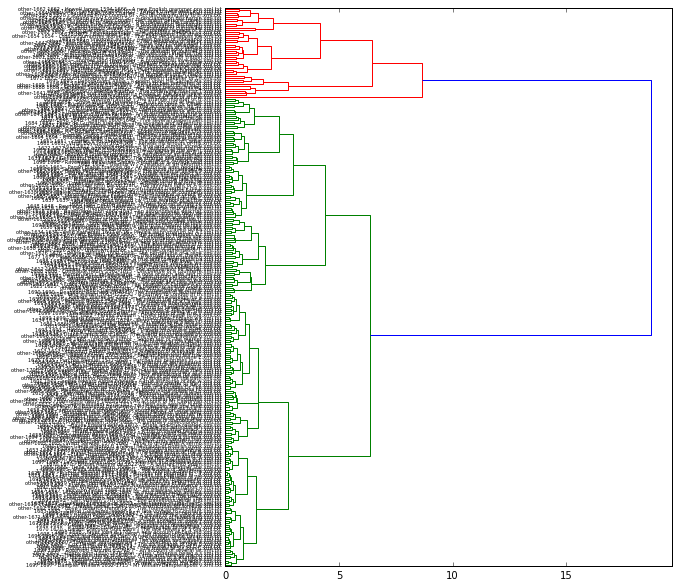

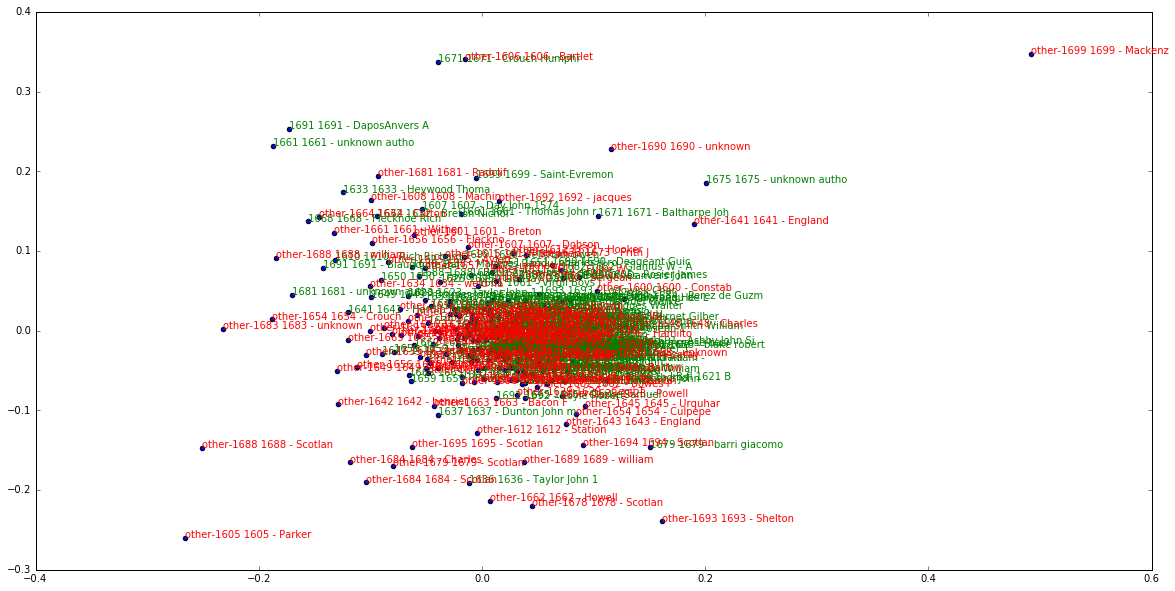

In [3]:
simple_vectorizer = TfidfVectorizer(use_idf=False)
plot_corpus_similarity(corpus, simple_vectorizer)

Well, it worked! Because I have so many files, the dendrogram is nigh unreadable, though it seems like there are certainly a lot of similarities between non/travel.

The scatter plot looks similar - travel looks slightly clustered, but not very distinctively. A few travel texts seem to be outliers to the entire corpus.

Well, continuing onward, let's refine using English stopwords – this will remove common function words from the relative term frequencies matrix. We'll also limit the number of terms considered to 5,000 for further efficiency.

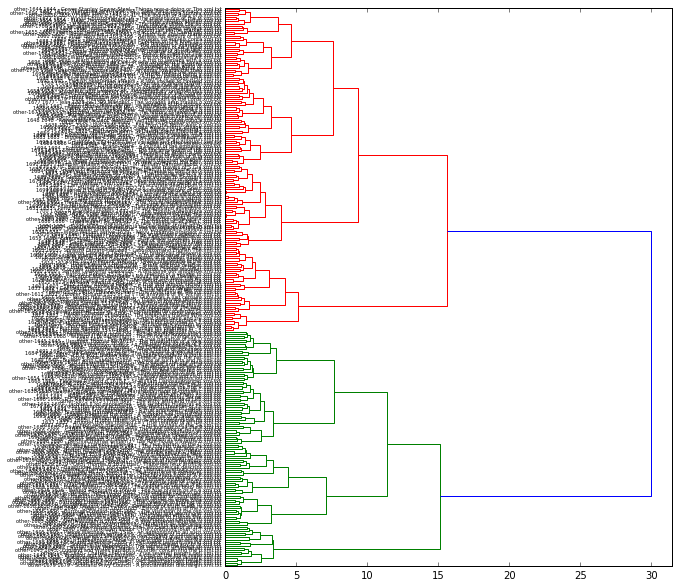

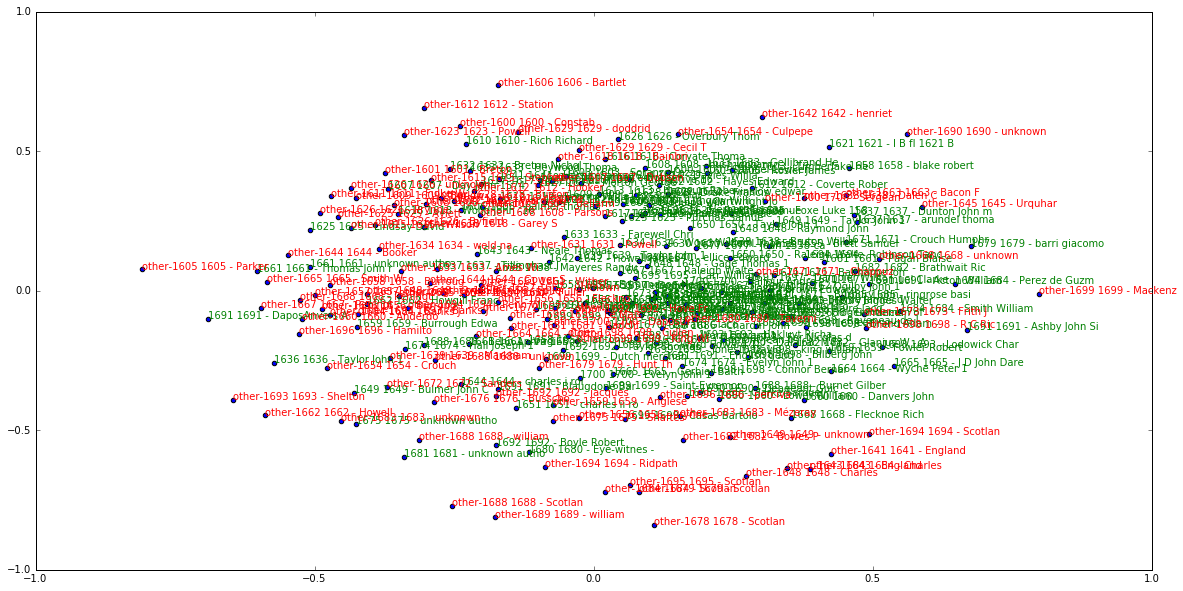

In [5]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=5000)
plot_corpus_similarity(corpus, stoplist_vectorizer)

Ah, at least this looks much more clustered, though there are still many travel outliers and some nontravel that appear to be quite similar! Let's take a look at some of the outliers, starting on the left - 
- 1625 Lindsay David - THE GODLY MANS IOVRNEY TO HEAVEN: CONTAINING TEN SEVERALL TREATISES. 
    - Apparently the Journey to Heaven is an outlier! I have no qualms about shifting this to nontravel.
- 1691 DaposAnvers Alicia - A POEM UPON His Sacred Majesty, His Uoyage for Holland: By way of DIALOGUE, BETWEEN Belgia and Britannia, By Mrs. D' ANVERS.
    - Although this one is less obvious, I still think it deserves to be shifted into nontravel. Although it is inspired by a potential Voyage, the content is a dialogue about personal qualities rather than travel.
- 1636 - Taylor John, TAYLORS TRAVELS AND CIRCVLAR PERAMBVLATION, through, and by more then thirty times twelve Signes of the Zodiack, of the Famous Cities of London and Westminster.
    - Oh dang. This one looks just like a travel text, though I think in general it seems odd! After a preface about astrological signs and wine, Taylor lists the signs of various vintners and taverns and sometimes writes epigrams. For example, 
                  Antwerp behind the Royall Exchange: 
                  Epigram.
                  Antwerp, is English'd, Throw thy hand Away,
                  Rather then God, or King, to disobey:
                  At Antwerp Taverne meet shake hands, be merry,
                  Ther's Clarret, White, Canary, and good Sherry.
        - So, again, while it positions itself as a travel text, that's really just a cover for being about wine and an Alphabeticall Description of the tavvern signs in the city. Into nontravel it goes!
        
What are some of the other texts that I will remove?
- 1675 - uknown author - THE Quakers Farewel to England, OR Their Voyage to New Jersey, scituate on the Continent of Virginia, and bordering upon New England.  To the Tune of, The Independes Voyage to New England.
- 1681 - unknown author - A new ballad of Jocky's Journey into England, in teh Year, 1681. With his Remarkes upon the Times.
- 1661 - MISERY to bee Lamented: Or, A Doleful Relation of the sad Accident which befell Lawrence Cawthorn, a Journey-man-Butcher (how did this get into my travel corpus?)
- 1651 - charles roi ii -    THE DECLARATION OF Captain JAMES HIND (close Prisoner in New-gate) and his Acknowledgment, Protestation, and full Confession at his Examination before the Councel of State (a small section on travel, but not as much as title suggests)
- 1661 Thomas, John - A Propheticall LOVE-SONG By one of the Sons of Zion, in the dayes of his Youth, in his Travel towards the Holy Land through the Wilderness. About morals and religion in a general sense.
- 1660 Danvers, John - THE ROYAL OAKE, OR, AN Historicall Description OF The Royal Progresse, vvonderful Travels Miraculous Escapes, and Strange Accidents of his Sacred Majesty CHARLES the II. - focuses more on the miracles, and less on the travel! Very sensational.
- 1649 Bulmer - A note of such Arts and Mysteries as an English Gentleman, a Souldier and a Traveller is able by Gods assistance to perform (he having means to perfect the same.) - very short - an advertisement, I believe! Interesting in its own right, but will throw off results of my machine learning because the genre/style is so different.
- 1668 - Flecknoe Richard d 1678 F - Sr William D'avenant's VOYAGE TO THE Other World: With His Adventures in the Poets ELIZIVM. Poetical Fiction. - largely a reflection upon Davenant's career, though with a few interesting nods to travel.
  
- 1658 - Blake's *A Lamentable Narration of the sad Disaster of a great part of the Spanish Plate-Fleet that perished neare St. Lucas* - kind of about travel, but mostly a sensational account of the battle.
   


Observations:
- Ballads seem to sometimes take travel as a starting point or inspiration, but aren't really about travel but other aspects. This points to travel's potential for discussing other matters.
- in general, verse, plays, and other non-prose works seem to have a different relative frequency and are often outliers to the main corpus.

I also found some texts that were in nontravel but were more accurately travel - or, at least, very closely related. For example, I moved the following into travel:
- 1680 1680 - Tavernier Jean-Baptiste 1 - A collection of several relations & Treatises Singular and Curious, of John Baptista Tavernier, Baron of Aubonne. Not Printed among his first Six voyages.
- 1671 - Chappuzeau's *THE HISTORY OF Jewels, And of the Principal Riches of the EAST and WEST. Taken from The Relation of Divers of the Most Famous Travellers of OƲR AGE.* It is a discussion of gems, but in this case, the history of gems seems to be a way to discuss foreign places!
       
            



   

### What does our new corpus look like?

Let's import our new corpus and run our same code on it to see what it looks like!

In [33]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

data_dir = "C:/Users/ASUS/Documents/iPython/data/DREaM"
corpusMod = PlaintextCorpusReader(data_dir+"/1600-1700corpusmod", ".*\.txt") 

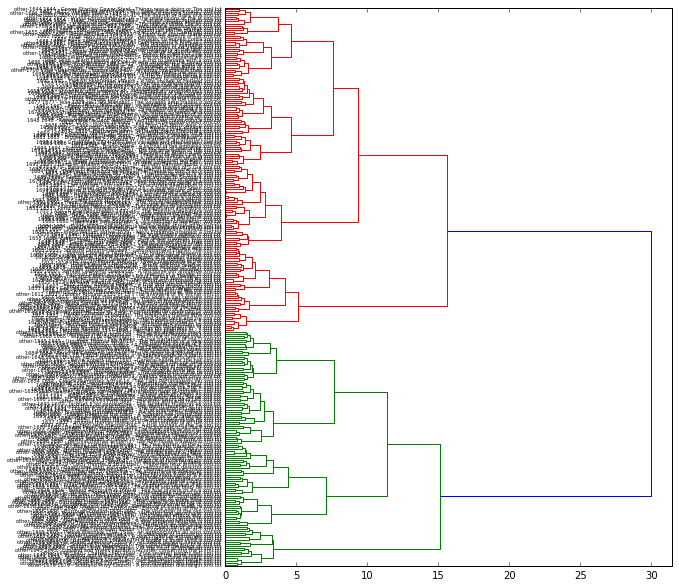

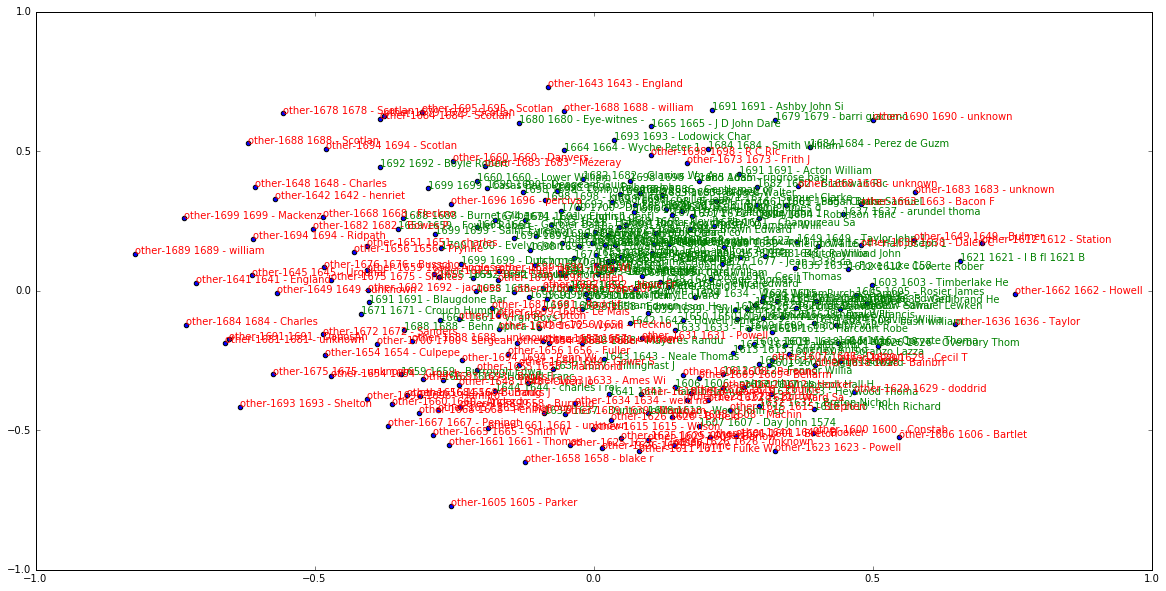

In [26]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=5000)
plot_corpus_similarity(corpusMod, stoplist_vectorizer)

#### Playing with variables

I want to know how changing certain variables may change the output.

For example, what if I change the number of features to something much lower? Let's say, 2500 instead of 5000?


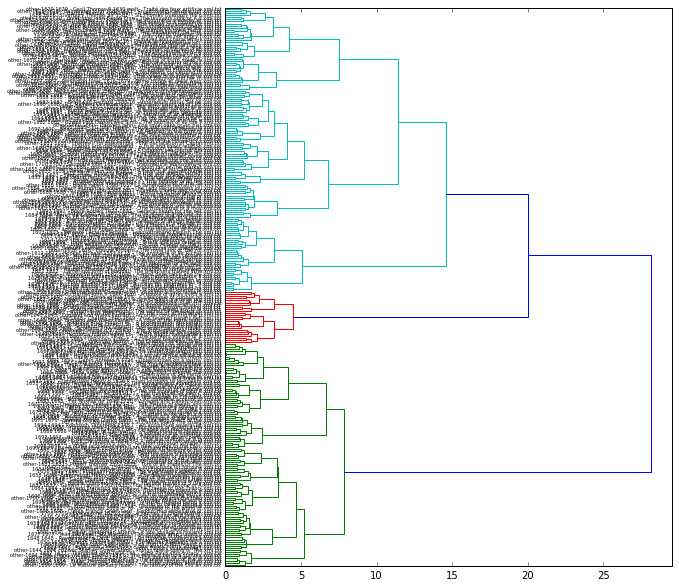

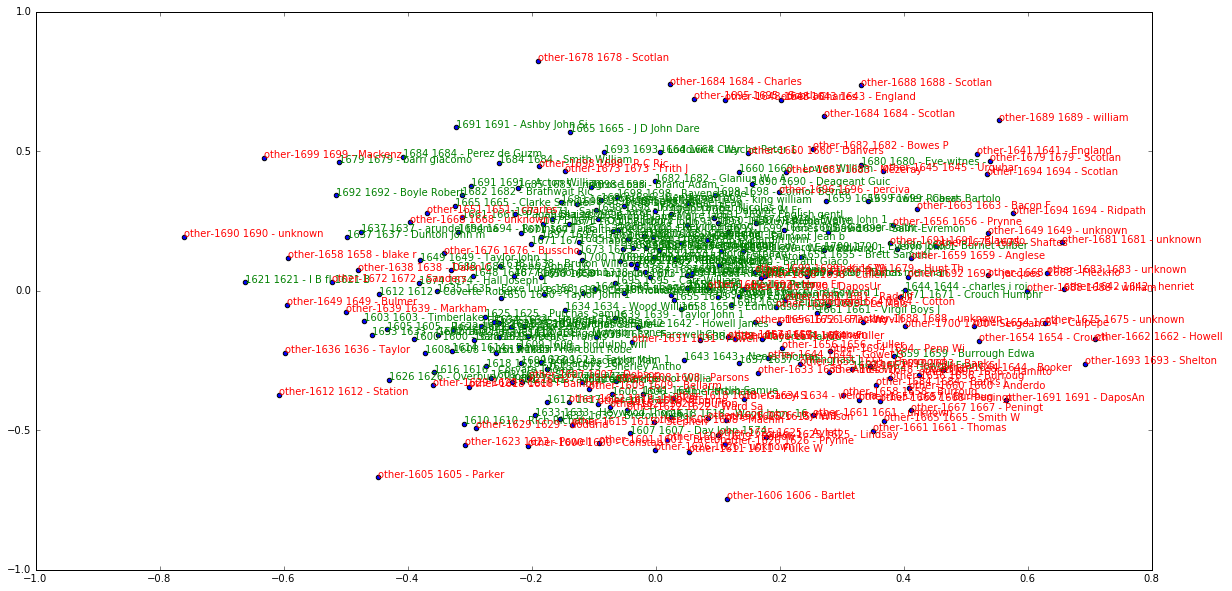

In [34]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=2500)
plot_corpus_similarity(corpusMod, stoplist_vectorizer)

What about if we increase the max features to 7500?

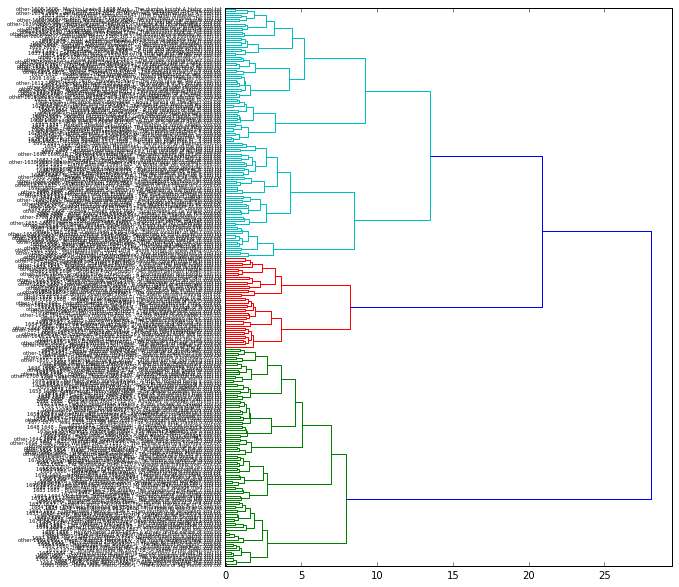

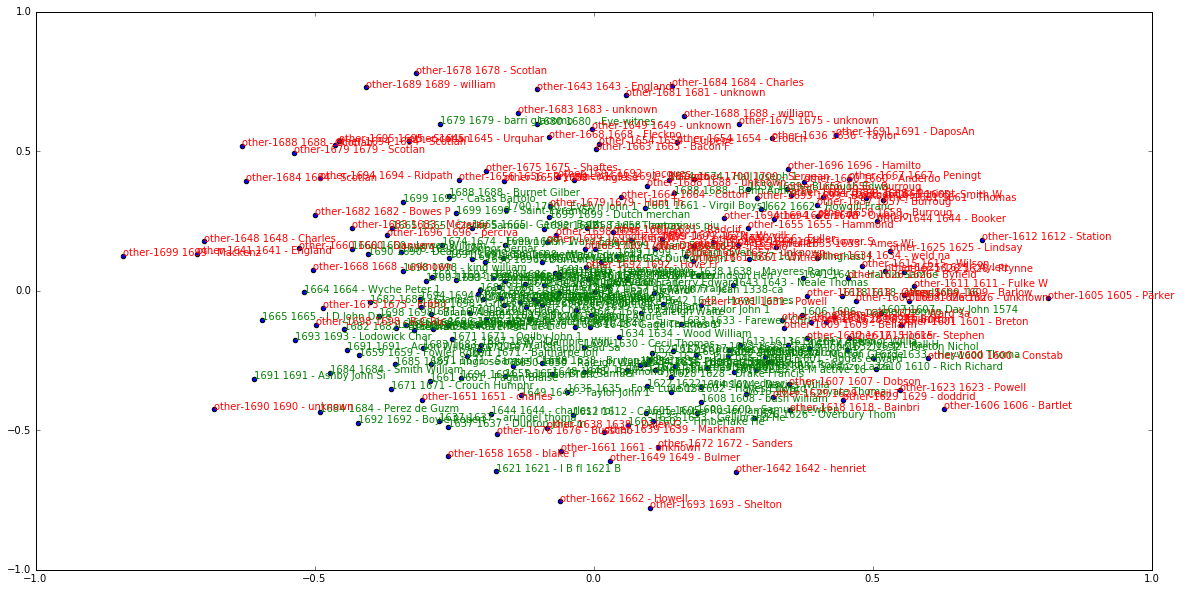

In [35]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=7500)
plot_corpus_similarity(corpusMod, stoplist_vectorizer)

It's certainly more spread out than the other two. I suppose that increasing the max features, that makes sense because travel lit would only have a limited vocabulary that isn't shared with others.

Crazy thought: what if we go very, very tiny?

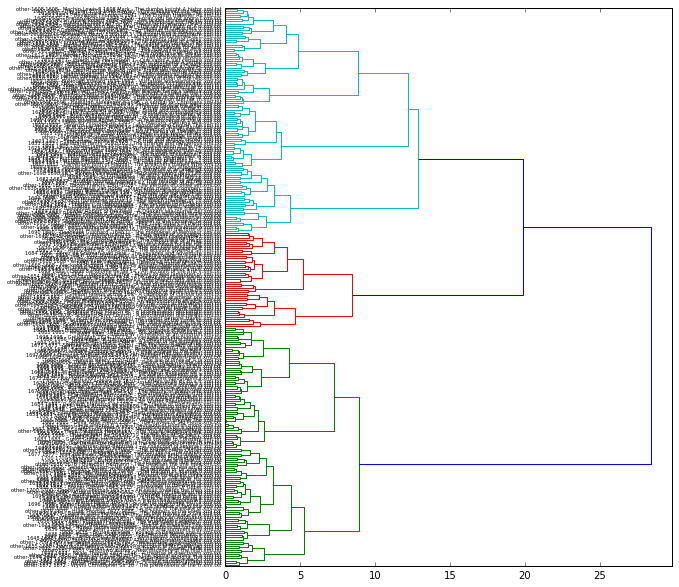

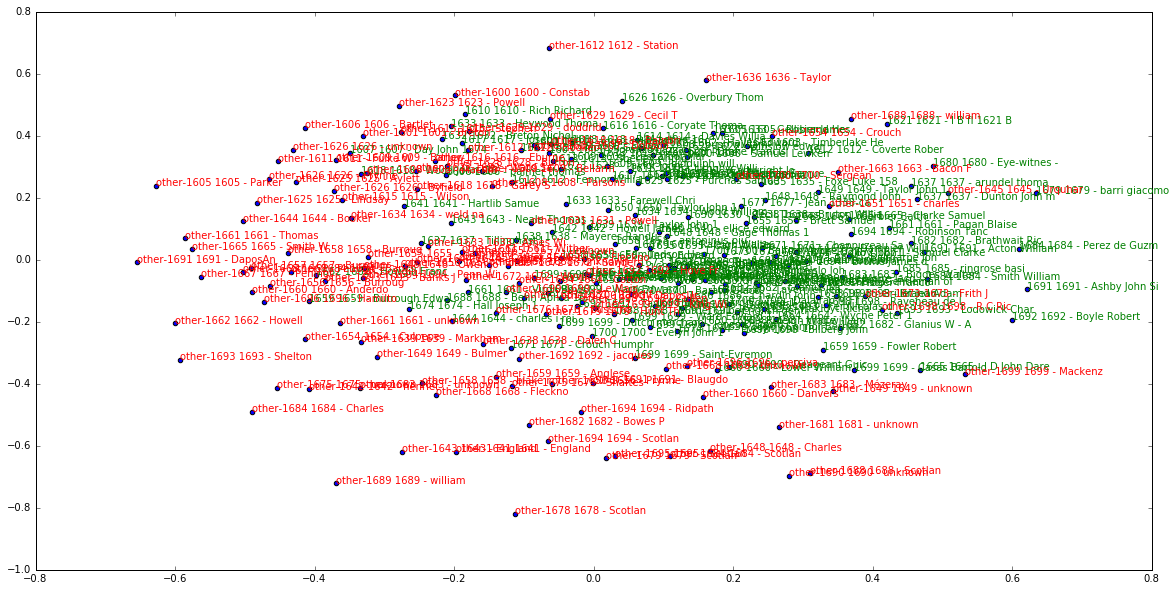

In [36]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=500)
plot_corpus_similarity(corpusMod, stoplist_vectorizer)

After looking at all these experiments, I actually think the 5000 feature set works the best. It's not as clear from looking at the scatterplot (perhaps because the titles distort the actual pattern - I might see very different texts to cut if the text went from right to left, for example), but the dendrogram for the 5000 feature set appears to be the most grouped.

So, when I'm working to narrow down my corpus, I will probably work with the 5000 feature set.

### But what about TF-IDF?

Earlier, we noted that we aren't using TF-IDF, because "it scales less well for dynamic and large corpora since we need to know in advance how many documents contain a given term."

But, out of curiousity, can we give TF-IDF a test run?

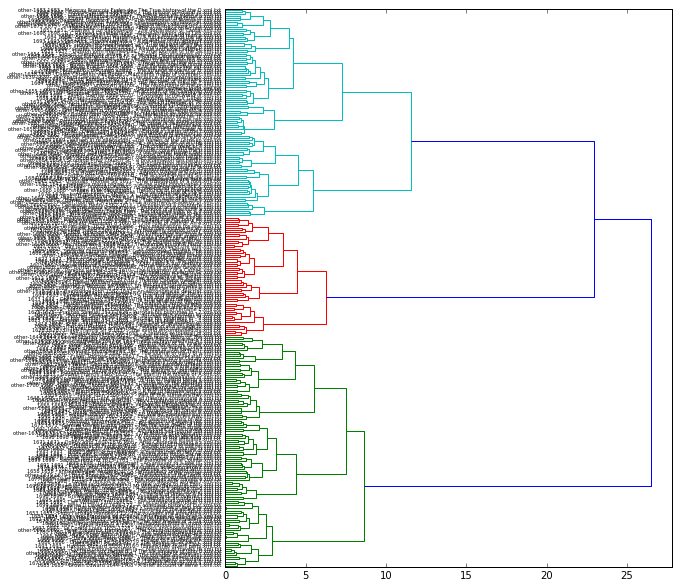

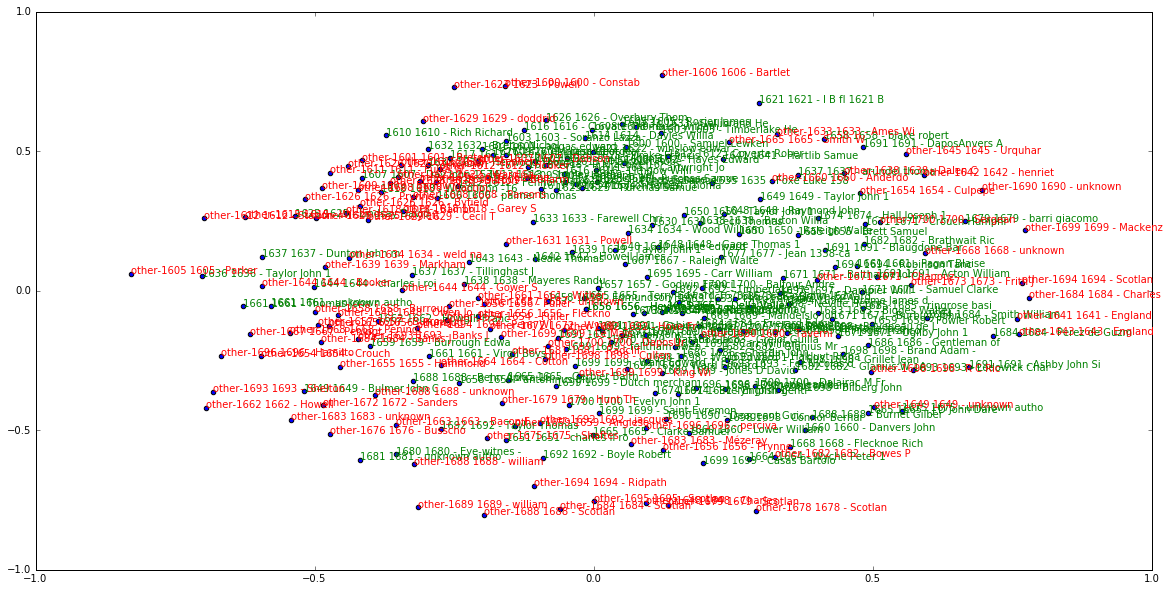

In [9]:
stoplist_vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words("english"), max_features=5000) 
# removed the use_idf=False
plot_corpus_similarity(corpus, stoplist_vectorizer)

Still similarly grouped, which is good, I suppose? But I don't exactly know how TF-IDF is interacting with my corpus, especially considering the above caveat. TF-IDF, conceptually, seems like it is more powerful (or more accurate? terminology?) than just relative frequency, but is limited by needing to know how many documents contain the term. This may be something to discuss with Stefan! 

In the CPT notebook, they run the same process with a keyword list. I'd be interested to see how that works on the corpus, but I don't have a keyword list prepared - dang! Easiest way to populate one might be to run over the travel corpus looking for word frequencies and maybe topics?

Until then, let's reflect on this process:

### observations and questions following document similarity

- how important is it to have a really concise corpus? That is, is it better to trim outliers like in the examples above?

- Answer: At this point, I feel confident that I have a corpus I can work with. I still have mixed feelings about cutting some of the texts, but I will move them and see if they get drawn back in. Additionally, I can always run the notebook again using other versions of the corpora to see if things change compared to other notebooks.

- is it too much to include poetry, prose, and plays? Or will focusing on one genre lead to better results? It's limiting my focus a bit, but that has both bad and good aspects.

## next steps: trimming the corpus

As I've mentioned, I have mixed feelings about refining my corpus. Part of the goal of this endeavour is to see whether things that might not be considered "travel literature" are drawn in by the machine learning, and to find noncanonical or unexamined texts. 

However, I think having a more accurate corpus is importnant, at least for an initial run-through. I am going to cut a few of the outliers and put them back into a general corpus - maybe they will be drawn back into the corpus later?

I assume it depends on the kind of machine learning whether relative frequencies are used or other things? Something to lookinto as I get more into reading ML materials.

Until then, I'm off to refine my corpus...

## Supervised Classification

I have my refined corpus! I removed 7 texts (and kept 2), and may remove more depending on what the below reveals. Let's take a look at it.

In [ ]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=5000)
plot_corpus_similarity(corpus2, stoplist_vectorizer)

Looks much cleaner! Let's see if I can throw it through a Supervised Classification, drawn (once again) from the Classifying Philosophical Texts notebook.


Supervised classification is essentially a process where we help the computer understand how known items (like texts) are classified in a training set, and then the computer tries to help us by classifying items it hasn't seen before. To determine the accuracy of a classifier, we can use a subset of our known items for training purposes and then test against another subset of our known items to see how many are correctly classified.

### Comparing Classifiers
In our case we have a total of known 147 texts, 69 of which are travel (not explicitly labelled as such) Question - should  there be equal numbers for training? and 78 of which are labelled as "Other". We can load all of our texts, randomized the order, and use half for training and half for testing (this ratio is maybe a bit unconventional because we have so few texts in our corpus, typically people use more of an 80/20 split between training and test sets).

There are many classifiers available and each one has parameters that can be tweaked. Which classifier and which parameters to use depend a lot on the data, the saying goes, but that's not very useful for us if we're just wanting to pick up a classifier and choose some settings. So let's begin by creating an algorithm to compare the accuracy of the classifiers.

Given a set of texts, we will:
shuffle the order randomly
choose half as training data and the other half as test data
create, train and test 13 classifiers (vaguely based on this example)
repeat this process a specified number of times (5 by default)
compare and graph the accuracy of each classifier by looking at the average accuracy for the number of repetitions

In [30]:
import random
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

def benchmark_svms(labelled_texts, runs, vectorizer):
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = ["Other" if "other-" in category else "Travel" for category, text in train_set]
        test_set_categories = ["Other" if "other-" in category else "Travel" for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (Perceptron(n_iter=50), "Perceptron"),
                (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='l2', penalty="l2", dual=False, tol=1e-3), "LinearSCV l2"),
                (LinearSVC(loss='l2', penalty="l1", dual=False, tol=1e-3), "LinearSCV l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l2"), "SGD l2"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l1"), "SGD l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid (aka Rocchio classifier"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            pred = clf.predict(X_test)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], index=[name for name,values in orderedresults])
    print("Ordered averages:")
    print(results_df.mean(axis=1).order(ascending=False))
    results_df.transpose().plot(figsize=(20, 10))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:299: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\svm\classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will 

Ordered averages:
NearestCentroid (aka Rocchio classifier    0.854135
Naïve Bayes Multinomial                    0.846617
LinearSCV l2                               0.845113
LinearSVC                                  0.845113
Ridge Classifier                           0.842105
LinearSCV l1                               0.831579
SGD elasticnet                             0.819549
SGD l2                                     0.815038
Passive-Aggressive                         0.813534
Perceptron                                 0.810526
SGD l1                                     0.809023
kNN                                        0.777444
Naïve Bayes Bernoulli                      0.745865
dtype: float64


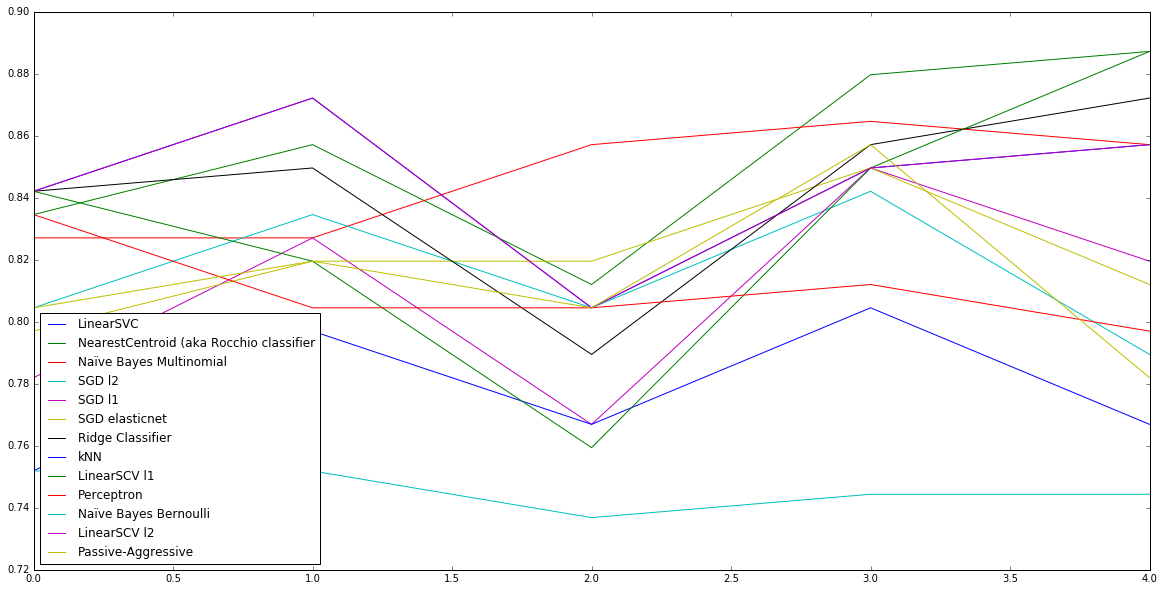

In [37]:
labelled_texts = [(fileid, corpusMod.raw(fileid)) for fileid in corpusMod.fileids()]
benchmark_svms(labelled_texts, 5, stoplist_vectorizer)